# LSTM Baseline

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from random import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

In [2]:
# straight from https://realpython.com/python-keras-text-classification/
def plot_history(history):
    """"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Loading and manipulating data

In [3]:
train_df = pd.read_json("train_df_final_LSTM.json").sample(frac=1) # sample(frac=1) is another way to shuffle data
dev_df = pd.read_json("dev_df_final_LSTM.json").sample(frac=1)
test_df = pd.read_json("test_df_final_LSTM.json").sample(frac=1)

# The full corpus, mean word count per review is ~56 words, while median is 45.
# LSTM-based models I experimented with a subset of training data really struggled,
# and one I thing I tried was cutting the max length to mitigate the extent
# of padding:

maxlen = 50

tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000)

train_text = list(train_df["text"].values)
tokenizer.fit_on_texts(train_text)

In [4]:
# The LSTM baseline was built with keras, rather than pytorch
X_train = tokenizer.texts_to_sequences(train_text)
X_train = keras.preprocessing.sequence.pad_sequences(X_train, padding="post", maxlen=maxlen)
train_y = list(train_df["labels"].values)
train_y = keras.utils.to_categorical(train_y, num_classes=49)
assert len(train_text) == len(train_y) == train_df.shape[0] == len(X_train)

dev_text = list(dev_df["text"].values)
X_dev = tokenizer.texts_to_sequences(dev_text)
X_dev = keras.preprocessing.sequence.pad_sequences(X_dev, padding="post", maxlen=maxlen)
dev_y = dev_df["labels"].values
dev_y = keras.utils.to_categorical(dev_y, num_classes=49)
assert len(dev_text) == len(dev_y) == dev_df.shape[0] == len(X_dev)

test_text = list(test_df["text"].values)
X_test = tokenizer.texts_to_sequences(test_text)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, padding="post", maxlen=maxlen)
test_y = test_df["labels"].values
test_y = keras.utils.to_categorical(test_y, num_classes=49)
assert len(test_text) == len(test_y) == test_df.shape[0] == len(X_test)

In [5]:
# used bits of this as a guide when switching to keras:
# https://keras.io/examples/nlp/pretrained_word_embeddings/

# This code also drew on old mittens code of mine, which undoubtedly drew on others' 
# work (e.g., blog posts) in addition to the official mittens documentation at 
# https://github.com/roamanalytics/mittens.
# Regrettably, I do not know where other sources of inspiration (or code) may have come from.

# In early experiments with LSTM-based models on a sample of training data,
# I compared mittens to vanilla GloVe using lighter-weight sets of pretrained 
# GloVe vectors such as the  Wikipedia/Gigaword vectors with a 400k token vocabulary.
# Using mittens didn't make much of a difference.

# When I switched to the Common Crawl GloVe vectors (vocab of 1.9 million), the computational
# difficulty of training the mittens vectors didn't seem to offset any (unexpected)
# increase in performance.

glove_dict = pickle.load(open("glove_lower_lg.d", "rb"))

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = list(glove_dict.values())[0].shape[0]

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, emb in glove_dict.items():
    if word in tokenizer.word_index:
        idx = tokenizer.word_index[word]
        embedding_matrix[idx] = np.array(emb, dtype=np.float32)

In [6]:
# I experimented with padding the zeroes in the embedding matrix and found it made no difference.
# I still kept this small shift when training my final model.
embedding_matrix += 0.0001

In [7]:
embedding_matrix

array([[ 1.00000000e-04,  1.00000000e-04,  1.00000000e-04, ...,
         1.00000000e-04,  1.00000000e-04,  1.00000000e-04],
       [-5.63020009e-03,  4.49410005e-01,  1.43660007e-01, ...,
        -1.66549997e-01, -3.73720007e-01, -1.46770002e-01],
       [-1.32709997e-01,  7.97179995e-02,  1.65580003e-01, ...,
         3.04609997e-01, -2.45989995e-01,  2.15190007e-01],
       ...,
       [-1.29880000e-02,  3.34150000e-01,  3.22749986e-01, ...,
        -5.35869988e-02,  2.14340000e-01, -2.10999997e-01],
       [ 1.00000000e-04,  1.00000000e-04,  1.00000000e-04, ...,
         1.00000000e-04,  1.00000000e-04,  1.00000000e-04],
       [ 1.00000000e-04,  1.00000000e-04,  1.00000000e-04, ...,
         1.00000000e-04,  1.00000000e-04,  1.00000000e-04]])

In [9]:
X_train.shape

(392000, 50)

### Selecting learning rate and optimizer after experimenting with layers and other hyperparameters

In [14]:
# sample_fraction = 0.2
# train_sample_size = int(sample_fraction * len(X_train))
# X_train_sample = X_train[:train_sample_size]
# train_y_sample = train_y[:train_sample_size]
# dev_sample_size = int(sample_fraction * len(X_dev))
# X_dev_sample = X_dev[:dev_sample_size]
# dev_y_sample = dev_y[:dev_sample_size]
# print(len(X_train_sample), len(train_y_sample))
# print(len(X_dev_sample), len(dev_y_sample))
    
# num_epochs = 3
# batch_size = 512

# r = -4*np.random.rand(4)
# alphas = [10**r_ for r_ in r]

# results = []

# for alpha in alphas:
#     optimizers = [keras.optimizers.Adam(learning_rate=alpha), tf.keras.optimizers.RMSprop(learning_rate=alpha),
#                   tf.keras.optimizers.Adagrad(learning_rate=alpha), tf.keras.optimizers.SGD(learning_rate=alpha)]
#     for optimizer in optimizers:
        
#         try:
#             del model
#         except:
#             pass
#         try:
#             del history
#         except:
#             pass
        
#         opt = optimizer
        
#         model = keras.models.Sequential()
#         model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
#                                    weights=[embedding_matrix], 
#                                    input_length=50, 
#                                    trainable=False))
#         model.add(keras.layers.Dropout(0.2))
#         model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True,
#                                                                kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
#                                                               activation="relu")))
#         model.add(keras.layers.Dropout(0.2))
#         model.add(keras.layers.LSTM(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5)))
#         model.add(keras.layers.Dense(49, activation="softmax"))

#         model.compile(optimizer=opt, # "adam"
#                       loss="categorical_crossentropy",
#                       metrics=["accuracy"])
#         model.summary()

#         model.fit(X_train_sample, train_y_sample, epochs=num_epochs, batch_size=batch_size)

#         loss, accuracy = model.evaluate(X_dev_sample, dev_y_sample)
        
#         result = [alpha, optimizer, loss, accuracy]
#         results.append(result)

In [11]:
sample_fraction = 0.2
train_sample_size = int(sample_fraction * len(X_train))
X_train_sample = X_train[:train_sample_size]
train_y_sample = train_y[:train_sample_size]
dev_sample_size = int(sample_fraction * len(X_dev))
X_dev_sample = X_dev[:dev_sample_size]
dev_y_sample = dev_y[:dev_sample_size]
print(len(X_train_sample), len(train_y_sample))
print(len(X_dev_sample), len(dev_y_sample))
    
num_epochs = 3
batch_size = 512

# started from -4 (four digits after decimal), like in class, and tried larger samples values
# I gradually narrowed it down, switching to -2 and trying fewer values
# r = -2*np.random.rand(2)                 
# alphas = [10**r_ for r_ in r]

# I eventually determined that learning rates in this range were working best
alphas = [0.105, 0.1, 0.11]

results = []

# I initially looped through, for each alpha, four different optimizers.
# I eventually excluded Adam and RMSProp, as Adagrad and SGD consistently worked best.
for alpha in alphas:
    optimizers = [tf.keras.optimizers.Adagrad(learning_rate=alpha), tf.keras.optimizers.SGD(learning_rate=alpha)]
    for optimizer in optimizers:
        
        try:
            del model
        except:
            pass
        try:
            del history
        except:
            pass
        
        opt = optimizer
        
        print(alpha, optimizer)
        
        model = keras.models.Sequential()
        model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                                   weights=[embedding_matrix], 
                                   input_length=50, 
                                   trainable=False))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True,
                                                               kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                                                              activation="relu")))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True,
                                                               kernel_regularizer=tf.keras.regularizers.l2(l2=1e-5),
                                                              activation="relu")))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(100, activation="relu"))
        model.add(keras.layers.Dropout(0.2))
        model.add(keras.layers.Dense(50, activation="relu"))
        model.add(keras.layers.Dense(49, activation="softmax"))

        model.compile(optimizer=opt, # "adam"
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])
        model.summary()

        model.fit(X_train_sample, train_y_sample, epochs=num_epochs, batch_size=batch_size)

        loss, accuracy = model.evaluate(X_dev_sample, dev_y_sample)
        
        result = [alpha, optimizer, loss, accuracy]
        results.append(result)
        
        print()
        print()
        print()

78400 78400
19600 19600
0.105 <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x0000027A0534BE80>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           23591100  
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 100)           140400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 100)           60400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
______

154/154 [==============================] - 77s 503ms/step - loss: 3.8992 - accuracy: 0.0218
Epoch 2/3
154/154 [==============================] - 77s 499ms/step - loss: 3.8978 - accuracy: 0.0228
Epoch 3/3
613/613 [==============================] - 10s 17ms/step - loss: 3.8959 - accuracy: 0.0240



0.11 <tensorflow.python.keras.optimizer_v2.adagrad.Adagrad object at 0x0000027AE8DF6D00>
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 300)           23591100  
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 300)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 50, 100)           140400    
_________________________________________________________________
dropout_17 (Dropout)         (None, 50, 100)           0       

In [16]:
# best results using a sample of the train and dev sets
# from sampling learning rates and trying them with different optimizers
results = sorted(results, key=lambda x: x[-1], reverse = True)
results

[[0.1,
  3.867598533630371,
  0.029285714030265808],
 [0.105,
  3.8780441284179688,
  0.027959182858467102],
 [0.11,
  3.8908610343933105,
  0.02709183655679226],
 [0.1,
  3.895852565765381,
  0.024030612781643867],
 [0.11,
  3.895056962966919,
  0.0234183669090271],
 [0.105,
  3.896501064300537,
  0.022295918315649033]]

## Final LSTM-base model for the baseline

392000 392000
98000 98000
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           23591100  
_________________________________________________________________
layer_normalization (LayerNo (None, 50, 300)           100       
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 100)           140400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 100)           60400     
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               500100    
_________________________________________________________________
dropout (Dropout)            (

766/766 [==============================] - 493s 643ms/step - loss: 3.2142 - accuracy: 0.1718 - val_loss: 3.1511 - val_accuracy: 0.1867
Epoch 47/50
766/766 [==============================] - 485s 633ms/step - loss: 3.2121 - accuracy: 0.1722 - val_loss: 3.1558 - val_accuracy: 0.1853
Epoch 48/50
766/766 [==============================] - 487s 636ms/step - loss: 3.2092 - accuracy: 0.1732 - val_loss: 3.1461 - val_accuracy: 0.1880
Epoch 49/50
766/766 [==============================] - 484s 632ms/step - loss: 3.2069 - accuracy: 0.1744 - val_loss: 3.1552 - val_accuracy: 0.1846
Epoch 50/50
12250/12250 [==============================] - 164s 13ms/step - loss: 3.0799 - accuracy: 0.2012
Train set accuracy: 0.2012
3063/3063 [==============================] - 40s 13ms/step - loss: 3.1442 - accuracy: 0.1896
Dev set accuracy:  0.1896
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not b

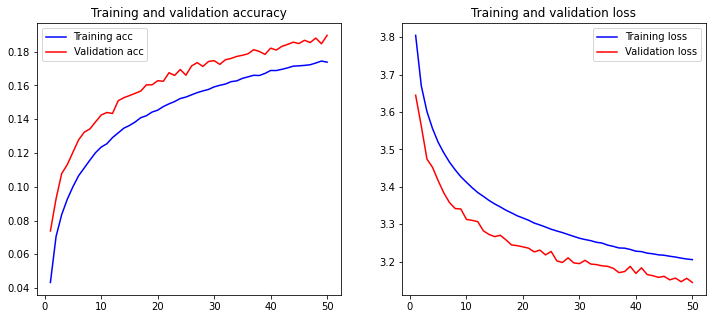

In [15]:
try:
    del model
except:
    pass
try:
    del history
except:
    pass

sample_fraction = 1.0

if sample_fraction < 1.0:
    train_sample_size = int(sample_fraction * len(X_train))
    X_train_sample = X_train[:train_sample_size]
    train_y_sample = train_y[:train_sample_size]
    dev_sample_size = int(sample_fraction * len(X_dev))
    X_dev_sample = X_dev[:dev_sample_size]
    dev_y_sample = dev_y[:dev_sample_size]
else:
    X_train_sample = X_train
    train_y_sample = train_y
    X_dev_sample = X_dev
    dev_y_sample = dev_y

print(len(X_train_sample), len(train_y_sample))
print(len(X_dev_sample), len(dev_y_sample))
    
num_epochs = 50
batch_size = 512

opt = tf.keras.optimizers.Adagrad(learning_rate=0.1) # I had determined that Adagrad with alpha=0.1 worked best

model = keras.models.Sequential()
model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=50, 
                           trainable=False))
model.add(keras.layers.LayerNormalization(axis=1))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True,
                                                       dropout=0.5,
                                                      activation="tanh")))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True,
                                                       dropout=0.5,
                                                      activation="tanh")))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation="tanh"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(50, activation="tanh"))
model.add(keras.layers.Dense(49, activation="softmax"))

model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

history = model.fit(X_train_sample, train_y_sample, epochs=num_epochs, verbose=True,
                    validation_data=(X_dev_sample, dev_y_sample), batch_size=batch_size,
                   shuffle = True)
loss, accuracy = model.evaluate(X_train_sample, train_y_sample, verbose=True)
print("Train set accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_dev_sample, dev_y_sample, verbose=True)
print("Dev set accuracy:  {:.4f}".format(accuracy))

try:
    model.save("LSTM_results/")
except:
    print("failed to save")

try:
    loss, accuracy = model.evaluate(X_test, test_y, verbose=True)
    with open("lstm_test_results.txt", "w") as writer:
        writer.write("{}\n{}".format(loss, accuracy))
except:
    print("failed to write test loss and accuracy")

plot_history(history)

In [19]:
pickle.dump(history.history, open("lstm_baseline_local_history_again.p", "wb"))

In [16]:
loss, accuracy = model.evaluate(X_test, test_y, verbose=True)

print(loss)
print("Test accuracy: ", accuracy)

1514/1514 [==============================] - 35s 23ms/step - loss: 3.1370 - accuracy: 0.1872
3.137021780014038
Test accuracy:  0.18719923496246338


In [21]:
y_pred = model.predict(X_test)

In [25]:
np.argmax(y_pred[0])

31

In [27]:
np.argmax(test_y[0])

44

In [30]:
# double-checking accuracy by hand
assert y_pred.shape[0] == test_y.shape[0]
assert y_pred.shape[1] == test_y.shape[1]

correct = 0
total = 0

for i, yhat in enumerate(y_pred):
    pred = np.argmax(yhat)
    actual = np.argmax(test_y[i])
    if pred == actual:
        correct += 1
    total += 1
    
print(correct/total)

0.18719923996778123


### Viewing and saving classification report info

In [38]:
y_pred_ = [np.argmax(yhat) for yhat in y_pred]
y_true_ = [np.argmax(y_) for y_ in test_y]

report = classification_report(y_true_, y_pred_, zero_division=0, output_dict=True)

report_df = pd.DataFrame(report).T.reset_index()

backward_d = {str(value):key for key, value in label_dict.items()}

report_df["occupation"] = [backward_d[str(lab)] if lab in [str(value) for value in label_dict.values()] else "" for lab in report_df["index"]]

report_df = report_df[["index", "occupation", "support", "f1-score", "precision", "recall"]]

report_df.to_json("cs230_classification_report_LSTM_local.json")

report_df

,index,occupation,support,f1-score,precision,recall
0,0,academic_counselor,1000.000000,0.242841,0.284182,0.212000
1,1,account_executive,1000.000000,0.221024,0.200653,0.246000
2,2,accounting,1000.000000,0.108573,0.074237,0.202000
3,3,administrative,1000.000000,0.070524,0.064356,0.078000
4,4,analyst,1000.000000,0.007401,0.049383,0.004000
5,5,beauty,1000.000000,0.333333,0.399441,0.286000
6,6,branch_manager,1000.000000,0.003956,0.181818,0.002000
7,7,business_analyst,1000.000000,0.087758,0.064336,0.138000
8,8,claims,1000.000000,0.193564,0.127370,0.403000
9,9,client_services,985.000000,0.007540,0.052632,0.004061


In [40]:
report_df.set_index("index").loc[["accuracy", "macro avg", "weighted avg"]]

,occupation,support,f1-score,precision,recall
index,,,,,
accuracy,,0.187199,0.187199,0.187199,0.187199
macro avg,,48419.000000,0.170579,0.197401,0.187352
weighted avg,,48419.000000,0.170350,0.196960,0.187199
